In [1]:
%%capture
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [3]:
from unsloth import FastVisionModel
import torch

fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
]

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.4: Fast Qwen2_Vl vision patching. Transformers: 4.46.3.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.36G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [4]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,

    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,

)

In [5]:
from datasets import load_dataset
dataset = load_dataset("unsloth/LaTeX_OCR", split = "train")

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

In [6]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

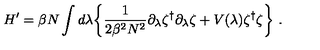

In [7]:
dataset[2]["image"]

In [8]:
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

In [9]:
from IPython.display import display, Math, Latex
latex = dataset[2]["text"]
display(Math(latex))

<IPython.core.display.Math object>

In [10]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

In [11]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [12]:
FastVisionModel.for_inference(model)

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

$$H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \right\} \, .$$<|im_end|>


In [13]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [14]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 50,855,936
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,1.177500
2,1.314500
3,1.440300
4,1.061800
5,0.999100
6,0.977600
7,0.792500
8,0.514900
9,0.383200
10,0.385400


In [15]:
FastVisionModel.for_inference(model)

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \right\} \ .<|im_end|>


In [16]:
model.save_pretrained("lora_model")

In [17]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model",
        load_in_4bit = True,
    )
    FastVisionModel.for_inference(model)

image = dataset[0]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

N \overline { M } \in \mathbb { Z } , M \overline { P } \in \mathbb { Z } , P \overline { Q } \in \mathbb { Z }<|im_end|>


In [18]:
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)